In [17]:
# installing packages
import sys
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "ggplot2"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import optuna
import imblearn as imb
from collections import Counter

from sklearn.metrics import (PrecisionRecallDisplay, precision_score,
recall_score,confusion_matrix,f1_score)
from sklearn.model_selection import train_test_split
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance)


In [18]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/testing_data.csv")
highcorr90 = pd.read_csv("../data/highcorr90.csv")
target="bankruptcy"

data = pd.concat([training_data,testing_data],axis=0).reset_index(drop=True)
print("Original Data Shape",data.shape)

data["company_type"] = data["company_type"].astype("category")

holdout=data.iloc[:50,:]
data = data.iloc[50:,:] 
print("Shape after dropping",data.shape)
X,y = data.drop(target,axis=1),data[target]

#Holdout
print("Shape of holdout",holdout.shape)
print(Counter(holdout[target]))

Original Data Shape (6811, 96)
Shape after dropping (6761, 96)
Shape of holdout (50, 96)
Counter({0: 47, 1: 3})


In [19]:
sampling_strategy=False
if sampling_strategy:
    # define oversampling strategy
    # oversample = RandomOverSampler(sampling_strategy='minority')
    oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.06)
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    print(Counter(y_over))
else :
    X_over = X.copy(deep=True)
    y_over = y.copy(deep=True)
    print(Counter(y_over))

Counter({0: 6545, 1: 216})


In [20]:
X_train,X_test,y_train,y_test = \
    train_test_split(X_over,y_over,test_size=0.3, stratify=y,random_state=42)

In [21]:
# X_train,y_train = training_data.drop("bankruptcy",axis = 1),training_data['bankruptcy']
# X_test,y_test = testing_data.drop("bankruptcy",axis = 1),testing_data['bankruptcy']
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4581, 1: 151})
Counter({0: 1964, 1: 65})


### Benchmark Model

Precision_Score: 0.05893019038984588,                Recall Score: 0.4304635761589404,                f1_score: 0.10366826156299841,
                confusion matrix: 
[[3543 1038]
 [  86   65]]
                classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4581
           1       0.06      0.43      0.10       151

    accuracy                           0.76      4732
   macro avg       0.52      0.60      0.48      4732
weighted avg       0.95      0.76      0.84      4732

Precision_Score: 0.05818965517241379,                Recall Score: 0.4153846153846154,                f1_score: 0.10207939508506615,
                confusion matrix: 
[[1527  437]
 [  38   27]]
                classification report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1964
           1       0.06      0.42      0.10        65

    accuracy                           

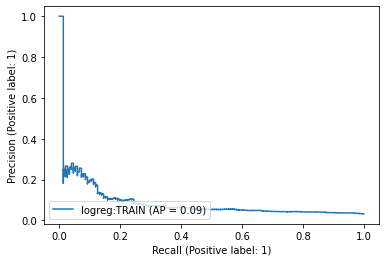

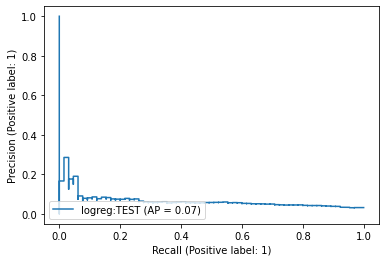

In [22]:
ohe = OneHotEncoder()

drop_high_corr = list(highcorr90["feat1"])
cat_cols = ["company_type"]
drop_cols_lr = drop_high_corr+cat_cols 
X_train_ohe = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

X_train_lr = X_train.drop(drop_cols_lr,axis=1).copy(deep=True)
X_test_lr = X_test.drop(drop_cols_lr,axis=1).copy(deep=True)

X_train_lr[ohe.categories_[0]] = X_train_ohe
X_test_lr[ohe.categories_[0]] = X_test_ohe


benchmark_mod = LogisticRegression(class_weight="balanced")
benchmark_mod.fit(X_train_lr,y_train)

pred_train_lr = benchmark_mod.predict_proba(X_train_lr)
pred_test_lr = benchmark_mod.predict_proba(X_test_lr)

model_performance(y_pred=pred_train_lr,y_true=y_train,threshold=0.5,
title="logreg:TRAIN",model_type="logreg")

model_performance(y_pred=pred_test_lr,y_true=y_test,threshold=0.5,
title="logreg:TEST",model_type="logreg")

In [23]:
# bbc = imb.ensemble.BalancedRandomForestClassifier(class_weight={0: 4581, 1: 151}).fit(X_train_lr,y_train)
# pred_train_bbc = bbc.predict_proba(X_train_lr)
# pred_test_bbc = bbc.predict_proba(X_test_lr)

# model_performance(y_pred=pred_train_bbc,y_true=y_train,threshold=0.5,
# title="bbc:TRAIN",model_type="bbc")

# model_performance(y_pred=pred_test_bbc,y_true=y_test,threshold=0.5,
# title="bbc:TEST",model_type="bbc")


In [58]:

def full_data(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,50),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30)
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, 
    early_stopping_rounds=10,cat_features=["company_type"]
    )

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [59]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(full_data, n_trials=50, timeout=600)

[I 2022-07-18 02:22:39,542] A new study created in memory with name: no-name-20c2eb18-7691-4df9-97f5-22ff92b4956a
[I 2022-07-18 02:22:39,909] Trial 0 finished with value: 0.33191489361702126 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.036249357693619914, 'learning_rate': 0.07490599637172995, 'depth': 6, 'iterations': 10, 'l2_leaf_reg': 10, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'scale_pos_weight': 14}. Best is trial 0 with value: 0.33191489361702126.
[I 2022-07-18 02:22:40,900] Trial 1 finished with value: 0.4497041420118343 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.049402699805386, 'learning_rate': 0.018832112777552215, 'depth': 8, 'iterations': 27, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'scale_pos_weight': 9, 'subsample': 0.7815960583476379}. Best is trial 1 with value: 0.4497041420118343.
[I 2022-07-18 02:22:45,458] Trial 2 finished with value: 0.3684210526315789 and parameters: {'objective

In [60]:
print("Number of finished trials: {}".format(len(study1.trials)))

print("Best trial:")
trial = study1.best_trial

print("  Value: {}".format(trial.value))

best_params={}
print("  Params: ")
for key, value in trial.params.items():
    best_params[key]=value
print(best_params)

Number of finished trials: 50
Best trial:
  Value: 0.5359477124183006
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.09650879908143059, 'learning_rate': 0.09303372013797777, 'depth': 5, 'iterations': 32, 'l2_leaf_reg': 3, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'scale_pos_weight': 6}


In [61]:
extra_params = {"cat_features":["company_type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":10
    #y_train.value_counts()[0]/y_train.value_counts()[1] 
    # "auto_class_weights":"Balanced"
    }
best_params = {**best_params, **extra_params}


In [62]:
best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.09650879908143059,
 'learning_rate': 0.09303372013797777,
 'depth': 5,
 'iterations': 32,
 'l2_leaf_reg': 3,
 'bootstrap_type': 'MVS',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 6,
 'cat_features': ['company_type']}

In [63]:
mod2 = CatBoostClassifier(**best_params)

mod2.fit(X_train,y_train)

# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

0:	learn: 0.5533579	total: 18.2ms	remaining: 565ms
1:	learn: 0.4698415	total: 31.1ms	remaining: 467ms
2:	learn: 0.3987303	total: 51.3ms	remaining: 496ms
3:	learn: 0.3602438	total: 67.4ms	remaining: 472ms
4:	learn: 0.3309445	total: 122ms	remaining: 661ms
5:	learn: 0.3101382	total: 153ms	remaining: 663ms
6:	learn: 0.2934403	total: 180ms	remaining: 645ms
7:	learn: 0.2708371	total: 197ms	remaining: 592ms
8:	learn: 0.2570432	total: 217ms	remaining: 555ms
9:	learn: 0.2482214	total: 240ms	remaining: 528ms
10:	learn: 0.2409314	total: 266ms	remaining: 507ms
11:	learn: 0.2353473	total: 300ms	remaining: 499ms
12:	learn: 0.2267261	total: 326ms	remaining: 477ms
13:	learn: 0.2215664	total: 340ms	remaining: 437ms
14:	learn: 0.2183951	total: 352ms	remaining: 399ms
15:	learn: 0.2137738	total: 366ms	remaining: 366ms
16:	learn: 0.2080440	total: 379ms	remaining: 334ms
17:	learn: 0.2046175	total: 392ms	remaining: 305ms
18:	learn: 0.2010691	total: 406ms	remaining: 278ms
19:	learn: 0.1964040	total: 422ms	rem

Precision_Score: 0.46218487394957986,                Recall Score: 0.7284768211920529,                f1_score: 0.5655526992287918,
                confusion matrix: 
[[4453  128]
 [  41  110]]
                classification report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4581
           1       0.46      0.73      0.57       151

    accuracy                           0.96      4732
   macro avg       0.73      0.85      0.77      4732
weighted avg       0.97      0.96      0.97      4732

Precision_Score: 0.4588235294117647,                Recall Score: 0.6,                f1_score: 0.5199999999999999,
                confusion matrix: 
[[1918   46]
 [  26   39]]
                classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1964
           1       0.46      0.60      0.52        65

    accuracy                           0.96      2029
   

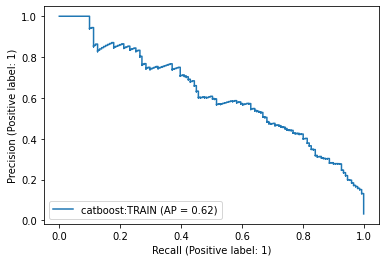

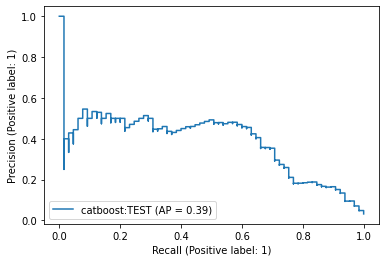

In [64]:
model_performance(y_pred=pred_train_cat,y_true=y_train,threshold=0.5,
title="catboost:TRAIN",model_type="catboost")

model_performance(y_pred=pred_test_cat,y_true=y_test,threshold=0.5,
title="catboost:TEST",model_type="catboost")


In [65]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)

In [66]:
top=50
importance_mod2 = get_shap_feat_importance(shap_values2,X_train)
importance_topk = importance_mod2[importance_mod2["shap_importance"]>0][:top]
best_feat = importance_topk.features.values

Net Worth: Net worth is the value of the assets a person or corporation owns, minus the liabilities they owe.

Debt Ratio = $\frac{TotalDebt}{TotalAssets}$

Class A and B shares: The difference between Class A shares and Class B shares of a company’s stock usually comes down to the number of voting rights assigned to the shareholder. Class A shareholders generally have more clout.

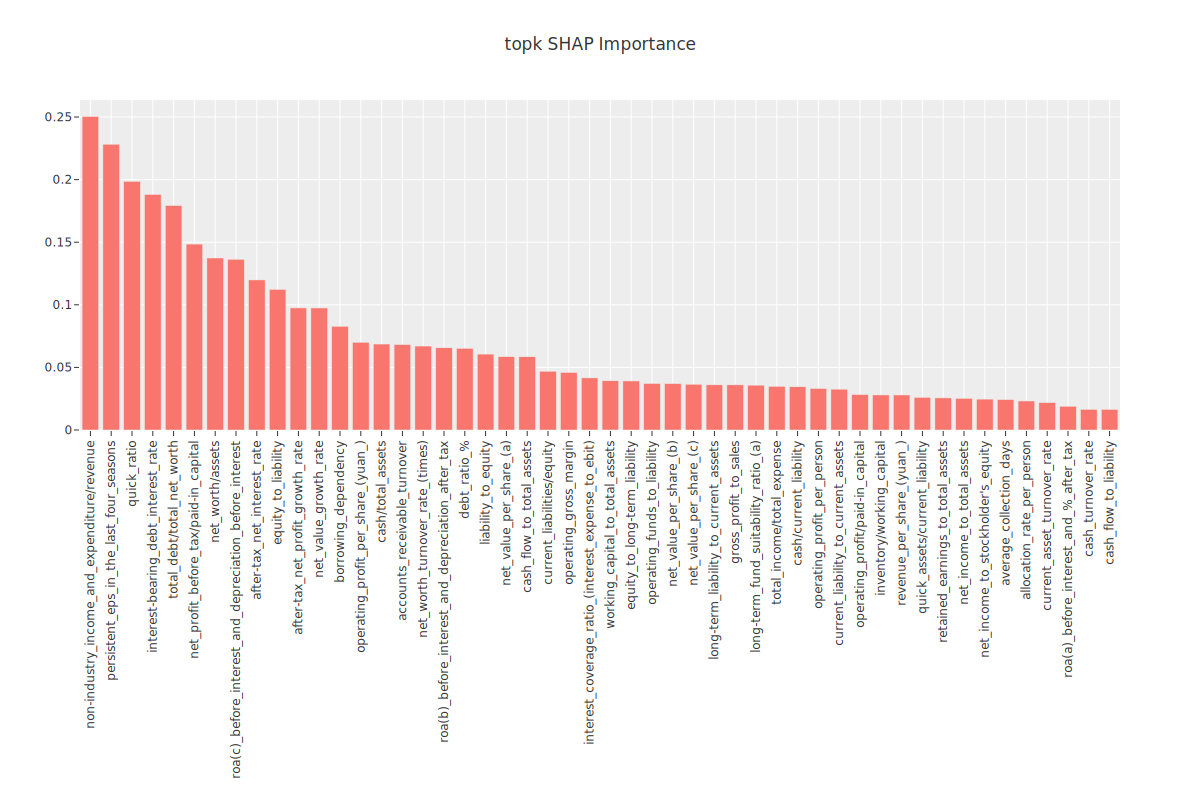

In [67]:
fig = go.Figure([go.Bar(x=importance_topk.features, y=importance_topk.shap_importance)])
fig.update_layout(width=1200, height=800,xaxis_tickangle=-90, title="topk SHAP Importance")
fig.show("svg")


In [69]:
if X_train[best_feat].select_dtypes(exclude=np.number).shape[1]>0:
    print(f"categorical feature detected")
else: 
    print(f"NO categorical feature detected")

NO categorical feature detected


In [70]:

def obj_best_feat(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,50),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30)
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train[best_feat], y_train, eval_set=[(X_test[best_feat], y_test)], verbose=0, 
    early_stopping_rounds=10#,cat_features=["company type"]
    )

    preds = gbm.predict(X_test[best_feat])
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [71]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(obj_best_feat, n_trials=50, timeout=600)

[I 2022-07-18 02:27:28,941] A new study created in memory with name: no-name-bad0cc30-079a-4d7e-be3d-a2ab0cba7115
[I 2022-07-18 02:27:29,181] Trial 0 finished with value: 0.41052631578947374 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011733577642174935, 'learning_rate': 0.07897312609769959, 'depth': 8, 'iterations': 34, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'scale_pos_weight': 23, 'bagging_temperature': 7.404758449336032}. Best is trial 0 with value: 0.41052631578947374.
[I 2022-07-18 02:27:29,687] Trial 1 finished with value: 0.33112582781456956 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07049889931769447, 'learning_rate': 0.0550496630300471, 'depth': 6, 'iterations': 39, 'l2_leaf_reg': 9, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'scale_pos_weight': 27}. Best is trial 0 with value: 0.41052631578947374.
[I 2022-07-18 02:27:31,046] Trial 2 finished with value: 0.4358974358974359 and parameters: 

In [72]:
print("Number of finished trials: {}".format(len(study2.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial2.value))

best_params2={}
print("  Params: ")
for key, value in trial2.params.items():
    best_params2[key]=value
print(best_params2)

Number of finished trials: 50
Best trial:
  Value: 0.49333333333333335
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.06686200153964729, 'learning_rate': 0.05905528103657172, 'depth': 10, 'iterations': 36, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'scale_pos_weight': 7, 'subsample': 0.5583484532375913}


In [73]:
extra_params = {
    #"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    #"auto_class_weights":"Balanced"
    }

best_params2 = {**best_params2, **extra_params}

In [74]:
best_params2

{'objective': 'Logloss',
 'colsample_bylevel': 0.06686200153964729,
 'learning_rate': 0.05905528103657172,
 'depth': 10,
 'iterations': 36,
 'l2_leaf_reg': 9,
 'bootstrap_type': 'Bernoulli',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7,
 'subsample': 0.5583484532375913}

In [93]:
best_params2_df = pd.DataFrame([best_params2])
best_params2_df.to_csv("../data/best_params.csv",index=False)

In [75]:
mod3 = CatBoostClassifier(**best_params2)

mod3.fit(X_train[best_feat],y_train)

# Get predicted probabilities for each class
pred_train_cat3 = mod3.predict_proba(X_train[best_feat])
pred_test_cat3 = mod3.predict_proba(X_test[best_feat])

0:	learn: 0.6137066	total: 63.1ms	remaining: 2.21s
1:	learn: 0.5501779	total: 215ms	remaining: 3.66s
2:	learn: 0.5001093	total: 224ms	remaining: 2.46s
3:	learn: 0.4533951	total: 330ms	remaining: 2.64s
4:	learn: 0.4150720	total: 348ms	remaining: 2.16s
5:	learn: 0.3849587	total: 417ms	remaining: 2.08s
6:	learn: 0.3730046	total: 419ms	remaining: 1.74s
7:	learn: 0.3510113	total: 495ms	remaining: 1.73s
8:	learn: 0.3230978	total: 575ms	remaining: 1.72s
9:	learn: 0.3200395	total: 585ms	remaining: 1.52s
10:	learn: 0.3054327	total: 657ms	remaining: 1.49s
11:	learn: 0.2878356	total: 699ms	remaining: 1.4s
12:	learn: 0.2779574	total: 741ms	remaining: 1.31s
13:	learn: 0.2661146	total: 776ms	remaining: 1.22s
14:	learn: 0.2561699	total: 894ms	remaining: 1.25s
15:	learn: 0.2481512	total: 950ms	remaining: 1.19s
16:	learn: 0.2421918	total: 952ms	remaining: 1.06s
17:	learn: 0.2359104	total: 1.02s	remaining: 1.02s
18:	learn: 0.2295619	total: 1.12s	remaining: 1s
19:	learn: 0.2239966	total: 1.12s	remaining:

Precision_Score: 0.49411764705882355,                Recall Score: 0.8344370860927153,                f1_score: 0.6206896551724138,
                confusion matrix: 
[[4452  129]
 [  25  126]]
                classification report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4581
           1       0.49      0.83      0.62       151

    accuracy                           0.97      4732
   macro avg       0.74      0.90      0.80      4732
weighted avg       0.98      0.97      0.97      4732

Precision_Score: 0.43529411764705883,                Recall Score: 0.5692307692307692,                f1_score: 0.49333333333333335,
                confusion matrix: 
[[1916   48]
 [  28   37]]
                classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1964
           1       0.44      0.57      0.49        65

    accuracy                           0

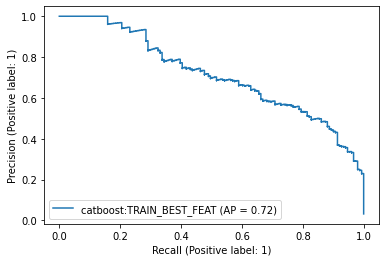

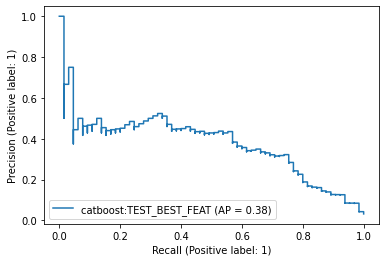

In [76]:
model_performance(y_pred=pred_train_cat3,y_true=y_train,threshold=0.5,
title="catboost:TRAIN_BEST_FEAT",model_type="catboost")

model_performance(y_pred=pred_test_cat3,y_true=y_test,threshold=0.5,
title="catboost:TEST_BEST_FEAT",model_type="catboost")


Precision_Score: 0.6666666666666666,                Recall Score: 0.6666666666666666,                f1_score: 0.6666666666666666,
                confusion matrix: 
[[46  1]
 [ 1  2]]
                classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.67      0.67      0.67         3

    accuracy                           0.96        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.96      0.96      0.96        50



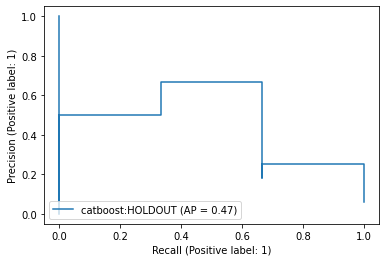

In [77]:
holdout_df = holdout.drop(target,axis = 1)[best_feat]
pred_holdout_cat = mod3.predict_proba(holdout_df)
model_performance(y_pred=pred_holdout_cat,y_true=holdout[target],threshold=0.5,
title="catboost:HOLDOUT",model_type="catboost")


In [95]:
#saving model
mod3.save_model(fname="../model/catboost_model",format="cbm")

In [78]:
explainer3 = shap.TreeExplainer(mod3)
shap_values3 = explainer3.shap_values(X_train[best_feat])

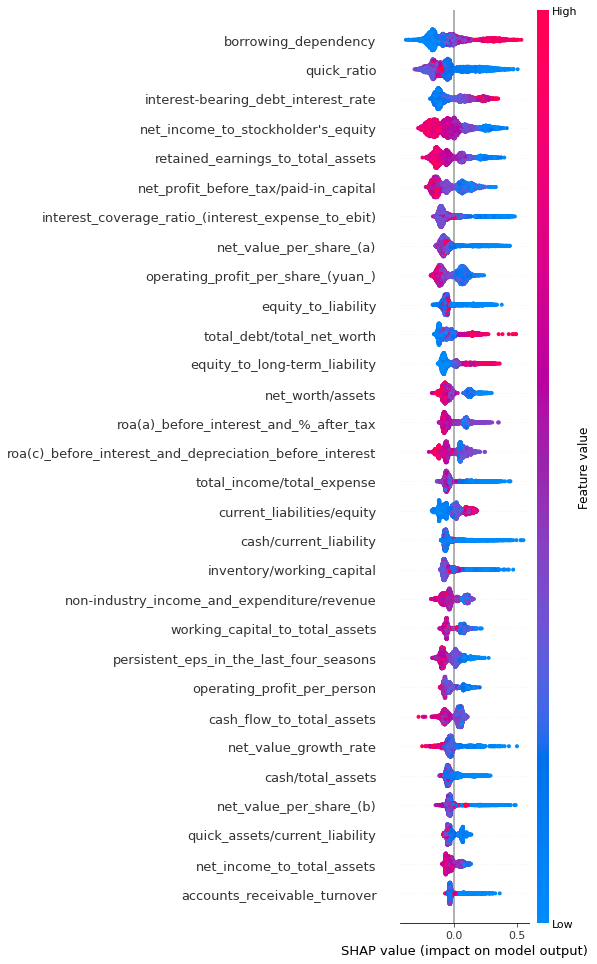

In [84]:
shap.summary_plot(shap_values3,X_train[best_feat],max_display=30)

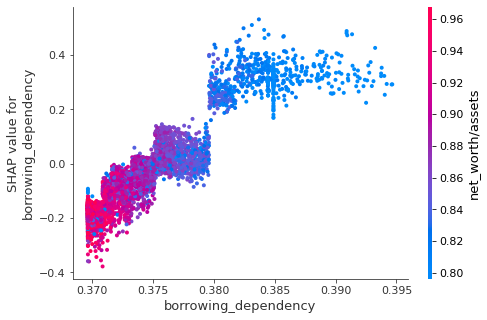

In [94]:
shap.dependence_plot("borrowing_dependency", shap_values3, X_train[best_feat],interaction_index="net_worth/assets")